## 09: Capacitated Facility Location Optimization with PuLP

**Goal:** To move from heuristic site selection (like in notebook 01) to formal optimization. We will solve a classic operations research problem: the **Capacitated Facility Location Problem**.

The problem answers the questions:
* **Which** of our potential facilities should we open?
* **How** should we assign demand from customers to these open facilities?

All while respecting that each facility has a **maximum capacity** and that our goal is to **minimize total costs** (a combination of fixed opening costs and variable travel costs).

We will use the `PuLP` library, a popular and intuitive linear programming tool in Python.

### 1. Setup and Library Imports

You'll need to install PuLP: `pip install pulp`

In [6]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary, LpStatus, value
from scipy.spatial.distance import cdist

### 2. Generate Synthetic Data

We need three datasets for this problem:
1.  A set of **customers** (or demand points), each with a certain level of demand.
2.  A set of **potential facility sites**, each with a fixed cost to open and a maximum service capacity.
3.  A **cost matrix** representing the travel cost from each customer to each facility (we'll use straight-line distance for this).

In [2]:
np.random.seed(42)

# 1. Customers
num_customers = 50
customers = pd.DataFrame({
    'id': range(num_customers),
    'demand': np.random.randint(10, 50, size=num_customers),
    'x': np.random.uniform(0, 100, size=num_customers),
    'y': np.random.uniform(0, 100, size=num_customers)
})

# 2. Potential Facilities
num_facilities = 10
facilities = pd.DataFrame({
    'id': range(num_facilities),
    'capacity': np.random.randint(100, 300, size=num_facilities),
    'opening_cost': np.random.randint(5000, 10000, size=num_facilities),
    'x': np.random.uniform(10, 90, size=num_facilities),
    'y': np.random.uniform(10, 90, size=num_facilities)
})

# 3. Travel Cost Matrix (distance)
customer_coords = customers[['x', 'y']].values
facility_coords = facilities[['x', 'y']].values
travel_costs = cdist(customer_coords, facility_coords, 'euclidean')

print(f"Total demand: {customers.demand.sum()}")
print(f"Total potential capacity: {facilities.capacity.sum()}")

Total demand: 1452
Total potential capacity: 2070


### 3. Formulate the Optimization Problem with PuLP

This involves defining our decision variables, objective function, and constraints.

In [3]:
# Create the LP problem
prob = LpProblem("FacilityLocation", LpMinimize)

# --- DECISION VARIABLES ---
# x_ij: fraction of demand from customer i served by facility j
assign_vars = LpVariable.dicts("Assign", 
                               ((i, j) for i in customers.id for j in facilities.id), 
                               lowBound=0, upBound=1, cat='Continuous')

# y_j: whether facility j is open (binary: 1 if open, 0 if closed)
open_vars = LpVariable.dicts("Open", facilities.id, cat=LpBinary)

# --- OBJECTIVE FUNCTION ---
# Minimize (total travel costs + total opening costs)
total_travel_cost = lpSum(travel_costs[i][j] * assign_vars[(i, j)] * customers.demand[i]
                          for i in customers.id for j in facilities.id)
total_opening_cost = lpSum(facilities.opening_cost[j] * open_vars[j] for j in facilities.id)
prob += total_travel_cost + total_opening_cost

# --- CONSTRAINTS ---
# Constraint 1: All customer demand must be met.
for i in customers.id:
    prob += lpSum(assign_vars[(i, j)] for j in facilities.id) == 1

# Constraint 2: The demand assigned to a facility cannot exceed its capacity.
for j in facilities.id:
    prob += lpSum(assign_vars[(i, j)] * customers.demand[i] for i in customers.id) <= facilities.capacity[j] * open_vars[j]

print("Optimization problem formulated.")

Optimization problem formulated.


### 4. Solve the Problem

In [7]:
prob.solve()

print(f"Status: {LpStatus[prob.status]}")
print(f"Optimal Total Cost: {value(prob.objective):,.2f}")

Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Mar  5 2025 

command line - cbc /var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/5caf7eb68975450e9e3d6217c26985e8-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/5caf7eb68975450e9e3d6217c26985e8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 65 COLUMNS
At line 1606 RHS
At line 1667 BOUNDS
At line 2178 ENDATA
Problem MODEL has 60 rows, 510 columns and 1010 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 75742.9 - 0.00 seconds
Cgl0004I processed model has 60 rows, 510 columns (10 integer (10 of which binary)) and 1010 elements
Cbc0038I Initial state - 4 integers unsatisfied sum - 1.20185
Cbc0038I Pass   1: suminf.    0.28302 (1) obj. 79363.7 iterations 16
Cbc0038I Solution found of 85439.4
Cbc0038I Relaxing continuous gives 81055.3
Cbc0038I Before mini

### 5. Visualize the Solution

We'll extract the results to see which facilities were opened and which customers they serve.

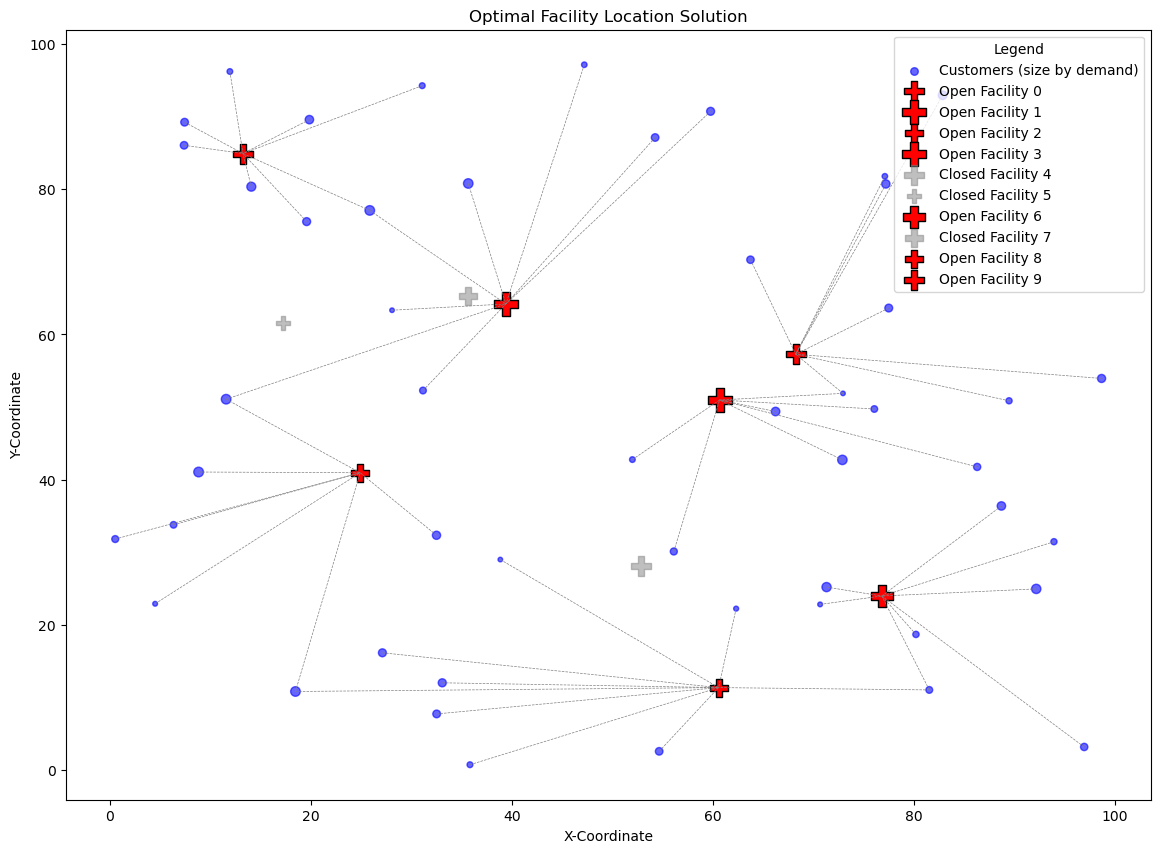

In [8]:
fig, ax = plt.subplots(figsize=(14, 10))

# Plot customers
ax.scatter(customers.x, customers.y, s=customers.demand, c='blue', alpha=0.6, label='Customers (size by demand)')

# Plot facilities
for j in facilities.id:
    if open_vars[j].varValue > 0.9: # If facility is open
        ax.scatter(facilities.x[j], facilities.y[j], marker='P', s=facilities.capacity[j], c='red', 
                   edgecolor='black', label=f'Open Facility {j}')
    else:
        ax.scatter(facilities.x[j], facilities.y[j], marker='P', s=facilities.capacity[j], c='gray', 
                   alpha=0.5, label=f'Closed Facility {j}')

# Plot assignment lines
for i in customers.id:
    for j in facilities.id:
        if assign_vars[(i,j)].varValue > 0.001:
            ax.plot([customers.x[i], facilities.x[j]], [customers.y[i], facilities.y[j]], 'gray', linestyle='--', linewidth=0.5)

plt.title('Optimal Facility Location Solution')
# Create a clean legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Legend')
plt.xlabel('X-Coordinate')
plt.ylabel('Y-Coordinate')
plt.show()

# Discussion:
# - The model has chosen a subset of the potential sites to open (red markers), leaving the others closed (gray markers).
# - It has optimally assigned each customer to an open facility, ensuring that no facility's capacity is exceeded and that total costs are minimized.
# - This formal optimization approach provides a mathematically provable best solution given the inputs, making it far more powerful than simple heuristics for high-stakes location decisions.